In [1]:
# Load TinyModel
from einops import rearrange
from tqdm import tqdm
from tinymodel import TinyModel, tokenizer
import torch
import nnsight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lm = TinyModel(n_layers=2, from_pretrained='tiny_model_2L_3E')
nnsight_lm = nnsight.NNsight(lm).to(device)

/root/sae-circuits/circuits2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/sae-circuits/circuits2/lib/python3.11/site-packages/tinymodel/tokenization/tokenization.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seri

# Autoencoder Definition

In [2]:
import einops
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoderTopK(nn.Module):
    """
    The top-k autoencoder architecture and initialization used in https://arxiv.org/abs/2406.04093
    NOTE: (From Adam Karvonen) There is an unmaintained implementation using Triton kernels in the topk-triton-implementation branch.
    We abandoned it as we didn't notice a significant speedup and it added complications, which are noted
    in the AutoEncoderTopK class docstring in that branch.

    With some additional effort, you can train a Top-K SAE with the Triton kernels and modify the state dict for compatibility with this class.
    Notably, the Triton kernels currently have the decoder to be stored in nn.Parameter, not nn.Linear, and the decoder weights must also
    be stored in the same shape as the encoder.
    """

    def __init__(self, activation_dim: int, dict_size: int, k: int):
        super().__init__()
        self.activation_dim = activation_dim
        self.dict_size = dict_size
        self.k = k

        self.encoder = nn.Linear(activation_dim, dict_size)
        self.encoder.bias.data.zero_()

        self.decoder = nn.Linear(dict_size, activation_dim, bias=False)
        self.decoder.weight.data = self.encoder.weight.data.clone().T
        self.set_decoder_norm_to_unit_norm()

        self.b_dec = nn.Parameter(torch.zeros(activation_dim))

    def encode(self, x: torch.Tensor, return_topk: bool = False):
        post_relu_feat_acts_BF = nn.functional.relu(self.encoder(x - self.b_dec))
        post_topk = post_relu_feat_acts_BF.topk(self.k, sorted=False, dim=-1)

        # We can't split immediately due to nnsight
        tops_acts_BK = post_topk.values
        top_indices_BK = post_topk.indices

        buffer_BF = torch.zeros_like(post_relu_feat_acts_BF)
        encoded_acts_BF = buffer_BF.scatter_(dim=-1, index=top_indices_BK, src=tops_acts_BK)

        if return_topk:
            return encoded_acts_BF, tops_acts_BK, top_indices_BK
        else:
            return encoded_acts_BF

    def decode(self, x: torch.Tensor) -> torch.Tensor:
        return self.decoder(x) + self.b_dec

    def forward(self, x: torch.Tensor, output_features: bool = False):
        encoded_acts_BF = self.encode(x)
        x_hat_BD = self.decode(encoded_acts_BF)
        if not output_features:
            return x_hat_BD
        else:
            return x_hat_BD, encoded_acts_BF

    @torch.no_grad()
    def set_decoder_norm_to_unit_norm(self):
        eps = torch.finfo(self.decoder.weight.dtype).eps
        norm = torch.norm(self.decoder.weight.data, dim=0, keepdim=True)
        self.decoder.weight.data /= norm + eps

    @torch.no_grad()
    def remove_gradient_parallel_to_decoder_directions(self):
        assert self.decoder.weight.grad is not None  # keep pyright happy

        parallel_component = einops.einsum(
            self.decoder.weight.grad,
            self.decoder.weight.data,
            "d_in d_sae, d_in d_sae -> d_sae",
        )
        self.decoder.weight.grad -= einops.einsum(
            parallel_component,
            self.decoder.weight.data,
            "d_sae, d_in d_sae -> d_in d_sae",
        )

    def from_pretrained(path, k: int, device=None):
        """
        Load a pretrained autoencoder from a file.
        """
        state_dict = torch.load(path)
        dict_size, activation_dim = state_dict["encoder.weight"].shape
        autoencoder = AutoEncoderTopK(activation_dim, dict_size, k)
        autoencoder.load_state_dict(state_dict)
        if device is not None:
            autoencoder.to(device)
        return autoencoder
    
class FeatureAutoEncoderTopK(AutoEncoderTopK):
    def __init__(self, activation_dim: int, dict_size: int, k: int, setting="normal"):
        super().__init__(activation_dim, dict_size, k)
        self.setting = setting

    def define_feature_by_feature_matrix(self):
        # turn off gradients to the decoder
        for param in self.decoder.parameters():
            param.requires_grad = False
        self.feature_by_feature = nn.Linear(self.dict_size, self.dict_size, bias=False)

    def initialize_feature_by_feature_matrix(self, decoder_weight):
        self.feature_by_feature.weight.data = self.encoder.weight.clone() @ decoder_weight.weight
    
    def feature_by_feature_forward(self, x: torch.Tensor):
        x = self.encode(x)
        return self.feature_by_feature(x)
        
    def from_pretrained(path, k: int, device=None, setting="normal"):
        """
        Load a pretrained autoencoder from a file.
        """
        state_dict = torch.load(path)
        dict_size, activation_dim = state_dict["encoder.weight"].shape
        autoencoder = FeatureAutoEncoderTopK(activation_dim, dict_size, k, setting=setting)
        autoencoder.load_state_dict(state_dict)
        if device is not None:
            autoencoder.to(device)
            
        if(setting == "feature_by_feature"):
            autoencoder.define_feature_by_feature_matrix()
            autoencoder.feature_by_feature.to(device)
            autoencoder.decoder.to("cpu")
                
        return autoencoder
    


# Load SAEs

In [6]:
from datasets import load_dataset, Dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
def download_dataset(dataset_name, tokenizer, max_length=256, num_datapoints=None):
    if(num_datapoints):
        split_text = f"train[:{num_datapoints}]"
    else:
        split_text = "train"
    dataset = load_dataset(dataset_name, split=split_text)
    print(dataset)
    total_failed_tokens = 0
    all_tokens = []
    for text in tqdm(dataset["text"]):
        try:
            tokens = [9996] + tokenizer.encode(text)[:max_length]
        except:
            total_failed_tokens += 1
            continue
        # only include if it's at least max_length
        if len(tokens) == max_length+1:
            all_tokens.append(tokens)
    print(f"Failed to tokenize {total_failed_tokens} tokens")
    # convert into a dataset class
    return  Dataset.from_dict({"input_ids": all_tokens})


dataset_name = "noanabeshima/TinyStoriesV2"
max_seq_length = 128
# num_datapoints = 70000 
# num_datapoints = 200000 # 24M tokens
num_datapoints = 800_000 # 100M tokens
# num_datapoints = 80_000 # 10M tokens
# max_seq_length = 100
# num_datapoints = 500
print(f"Downloading {dataset_name}")
dataset = download_dataset(dataset_name, tokenizer=tokenizer, max_length=max_seq_length, num_datapoints=num_datapoints)
true_num_datapoints = len(dataset)
# added BOS
max_seq_length +=1
total_tokens = max_seq_length * true_num_datapoints
print(f"Number of datapoints w/ {max_seq_length} tokens: {true_num_datapoints}")
print(f"Total Tokens: {total_tokens / 1e6}M")

batch_size = 512
with dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)

Dataset({
    features: ['text'],
    num_rows: 800000
})


100%|██████████| 800000/800000 [23:58<00:00, 556.27it/s]


Failed to tokenize 52 tokens
Number of datapoints w/ 129 tokens: 756718
Total Tokens: 97.616622M


In [19]:
import os
import sys
from pathlib import Path

# Get the path to the project root (sae-circuits)
project_root = str(Path.cwd().parent)

# Add the project root to sys.path
sys.path.append(str(project_root))
# Load SAEs
# Just last SAE & Transcoder
last_sae_path = project_root + '/saes/resid_final.pt'
transcoder_path = project_root + '/saes/transcoder1.pt'

k = 30
# Load SAE model definition
transcoder_f2f = FeatureAutoEncoderTopK.from_pretrained(transcoder_path, k, device=device, setting="feature_by_feature")
transcoder = FeatureAutoEncoderTopK.from_pretrained(transcoder_path, k, device=device, setting="normal")
normal_transcoder = FeatureAutoEncoderTopK.from_pretrained(transcoder_path, k, device=device, setting="normal")
resid_sae = AutoEncoderTopK.from_pretrained(last_sae_path, k, device=device)
# Ensure gradients are off for sae_downstream (ie last_sae)
# for param in resid_sae.parameters():
#     param.requires_grad = False

randomize_weights = False
if randomize_weights:
    input_shape, output_shape = transcoder.encoder.weight.shape
    transcoder.encoder.weight.data = torch.randn(input_shape, output_shape)
    transcoder.encoder.bias.data = torch.randn(input_shape)
    transcoder.decoder.weight.data = torch.randn(output_shape, input_shape)
    transcoder.b_dec.data = torch.randn(output_shape)
    transcoder.to(device)
saes_feature_to_feature = [transcoder, resid_sae]
# saes_normal = [normal_transcoder, resid_sae]
# initialize transcoder_f2f decoder to be dec @ enc
transcoder_f2f.initialize_feature_by_feature_matrix(resid_sae.encoder)

/tmp/ipykernel_286421/657437411.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)
/tmp/ipykernel_286421/657437411.py:84: FutureWarning: You

In [23]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import gc

def train_model(model, saes, dl):
    # loss_setting = "local_loss"
    loss_setting = "feature_loss"
    device = nnsight_lm.device
    # settings: normal: usual decoder
    #           feature_by_feature: feature_by_feature decoder
    check_batch_steps = 30

    
    losses = []
    mse_losses = []
    sparsity_losses = []
    original_ces = []
    only_final_sae_ces = []
    transcoder_ces = []
    compounded_ces = []
    sae_upstream, sae_downstream = saes
    setting = sae_upstream.setting

    opt = torch.optim.Adam(sae_upstream.parameters(), lr=1e-3)

    for batch_ind, batch in enumerate(dl):
        batch = batch.to(device)

        resid_mid = model.torso[1].res_mlp
        resid_final = model.torso[1].res_final
        mlp_out = model.torso[1].mlp
        with torch.no_grad(), model.trace(batch) as tracr:
            act_res_mid = resid_mid.output.save()
            act_res_final = resid_final.output.save()
            act_mlp_out = mlp_out.output.save()
        # act_res_mid = rearrange(act_res_mid, 'b s d -> b (s d)')
        # act_res_final = rearrange(act_res_final, 'b s d -> b (s d)')

        features_downstream = sae_downstream.encode(act_res_final)
        # norm_of_res_final = act_res_final.norm(p=2)
        # norm_of_res_mid = act_res_mid.norm(p=2)
        # norm_of_features_downstream = features_downstream.norm(p=2)
        # print(f"Norm of Res Final: {norm_of_res_final.item():.3f}, Norm of Res Mid: {norm_of_res_mid.item():.3f}, Norm of Features Downstream: {norm_of_features_downstream.item():.3f}")
        if(setting == "normal"):
            # Resid_feautures = topk(ReLU(Enc(Resid_mid + mlp_out)), k)
            # Resid_feautures = topk(ReLU(Enc([Resid_mid_feat_cont] + [mlp_out_hat])), k)
            # Resid_feautures = Encode([Resid_mid_feat_cont] + [mlp_out_hat])
            mlp_out_hat = sae_upstream(act_res_mid)
            features_downstream_hat = sae_downstream.encode(mlp_out_hat + act_res_mid)
        elif(setting == "feature_by_feature"):
            # Resid_feautures = topk(ReLU(Enc(Resid_mid) + Enc(mlp_out)), k)
            # Resid_feautures = topk(ReLU(Enc(Resid_mid) + Enc(mlp_out)), k)
            transcoder_features_contribution = sae_upstream.feature_by_feature_forward(act_res_mid)

            # Topk 
            #TODO: how to deal w/ bias_decoder (in downstream SAE)? 
            resid_mid_feature_contribution = sae_downstream.encoder(act_res_mid - sae_downstream.b_dec)
            post_relu_feat_acts_BF = nn.functional.relu(resid_mid_feature_contribution + transcoder_features_contribution)
            post_topk = post_relu_feat_acts_BF.topk(sae_downstream.k, sorted=False, dim=-1)

            tops_acts_BK = post_topk.values
            top_indices_BK = post_topk.indices

            buffer_BF = torch.zeros_like(post_relu_feat_acts_BF)
            features_downstream_hat = buffer_BF.scatter_(dim=-1, index=top_indices_BK, src=tops_acts_BK)

        else:
            raise ValueError(f"Invalid setting: {setting}")


        def _log_cosh(x: torch.Tensor) -> torch.Tensor:
            return x + torch.nn.functional.softplus(-2. * x) - torch.log(torch.tensor(2.0))

        if(loss_setting == "local_loss"):
            # Do mlp
            mse_loss = ((act_mlp_out - mlp_out_hat)**2).sum(dim=-1).mean()
        else: # Feature reconstruction
            mse_loss = torch.mean(_log_cosh(features_downstream_hat - features_downstream))
            # mse_loss = ((features_downstream - features_downstream_hat)**2).sum(dim=-1).mean()
            # mse_loss += ((act_mlp_out - mlp_out_hat)**2).sum(dim=-1).mean()

        # TODO: maybe log-cosh loss?m = feature_acts_downstream.view(-1, feature_acts_downstream.size(-1))
        # sparsity_loss
        if(setting=="normal"):
            # TODO: check shape
            feature_by_feature_matrix = sae_upstream.decoder.weight.T@sae_downstream.encoder.weight.T
        elif(setting=="feature_by_feature"):
            feature_by_feature_matrix = sae_upstream.feature_by_feature.weight
        
        # Set decoder norm to unit norm
        sae_upstream.set_decoder_norm_to_unit_norm()

        # L0 norm
        # sparsity_loss = feature_by_feature_matrix.norm(p=0)
        sparsity_loss = torch.tensor([0]).to(device)
        
        sparsity_lambda = 1e-3
        loss = mse_loss + sparsity_lambda*sparsity_loss       

        # Every few epochs, calculate the CE-diff
        if batch_ind % check_batch_steps == 0:
            unembedding_matrix = model.lm_head.weight.T
            with torch.no_grad():
                # Pretty Expensive, so let's delete as we go

                # Define CE loss
                loss_fn = nn.CrossEntropyLoss()

                # Format batch
                batch = batch[:, 1:]
                batch = batch.reshape(-1)  # shape: (batch_size * (seq_len - 1))

                # Calculate original logits
                original_logits = act_res_final @ unembedding_matrix
                original_logits = original_logits[:, :-1, :].reshape(-1, original_logits.size(-1))  # shape: (batch_size * (seq_len - 1), vocab_size)
                # Calculate CE loss
                original_ce = loss_fn(original_logits, batch).cpu()

                del original_logits
                gc.collect()
                torch.cuda.empty_cache()

                only_final_sae_logits = sae_downstream(act_res_final) @ unembedding_matrix
                only_final_sae_logits = only_final_sae_logits[:, :-1].reshape(-1, only_final_sae_logits.size(-1))
                only_final_sae_ce = loss_fn(only_final_sae_logits, batch).cpu()
                
                del only_final_sae_logits
                gc.collect()
                torch.cuda.empty_cache()

                # transcoder + Last SAE CE: ie true compounded CE comparison (Need good transcoder first)
                # only_final_sae_logits = sae_downstream(act_res_final) @ unembedding_matrix
                # only_final_sae_logits = only_final_sae_logits[:, :-1].reshape(-1, only_final_sae_logits.size(-1))
                # only_final_sae_ce = loss_fn(only_final_sae_logits, batch).cpu()
                
                # del only_final_sae_logits
                # gc.collect()
                # torch.cuda.empty_cache()

                mlp_out_hat = sae_upstream(act_res_mid)
                transcoder_only_logits = (mlp_out_hat + act_res_mid) @ unembedding_matrix
                transcoder_only_logits = transcoder_only_logits[:, :-1].reshape(-1, transcoder_only_logits.size(-1))
                transcoder_ce = loss_fn(transcoder_only_logits, batch).cpu()

                # del transcoder_only_logits
                gc.collect()
                torch.cuda.empty_cache()

                if(loss_setting=="local_loss"):
                    compounded_logits = sae_downstream(mlp_out_hat + act_res_mid) @ unembedding_matrix
                else:
                    compounded_logits = sae_downstream.decode(features_downstream_hat) @ unembedding_matrix
                compounded_logits = compounded_logits[:, :-1].reshape(-1, compounded_logits.size(-1))
                compounded_ce = loss_fn(compounded_logits, batch).cpu()

                del compounded_logits
                gc.collect()
                torch.cuda.empty_cache()

                print(f"{batch_ind}/{len(dl)}|Orig-CE: {original_ce.item():.3f}, Fin-CE: {only_final_sae_ce.item():.3f}, trans-only-CE: {transcoder_ce.item():.3f}, Comp-CE: {compounded_ce.item():.3f} L1: {sparsity_loss.item():.3f}, MSE: {mse_loss.item():.4f}")
                # print(f"{batch_ind}/{len(dl)}|Orig-CE: {original_ce.item():.3f}, Fin-CE: {only_final_sae_ce.item():.3f}, Comp-CE: {compounded_ce.item():.3f} L1: {sparsity_loss.item():.3f}, MSE: {mse_loss.item():.3f}")
                # print(f"MSE Loss: {mse_loss.item():.3f}, Sparsity Loss: {sparsity_loss.item():.3f}")
                # print(f"Only Final SAE CE: {only_final_sae_ce.item():.3f}")
                # print(f"Perturbed CE: {compounded_ces.item():.3f}")
                # print(f"Sparsity Loss: {sparsity_loss.item():.3f}")
                # print(f"MSE Loss: {mse_loss.item():.3f}")

            # store the losses
            mse_losses.append(mse_loss.item())
            sparsity_losses.append(sparsity_loss.item())
            original_ces.append(original_ce.item())
            only_final_sae_ces.append(only_final_sae_ce.item())
            # transcoder_ces.append(transcoder_ce.item())
            compounded_ces.append(compounded_ce.item())
        
        loss.backward()
        sae_upstream.remove_gradient_parallel_to_decoder_directions()
        opt.step()
        opt.zero_grad()

    return [mse_losses, sparsity_losses, original_ces, only_final_sae_ces, compounded_ces]

# losses_normal = train_model(nnsight_lm, saes_normal, dl)
losses_feature_by_feature = train_model(nnsight_lm, saes_feature_to_feature, dl)

0/1478|Orig-CE: 1.143, Fin-CE: 1.347, trans-only-CE: 1.325, Comp-CE: 1.479 L1: 0.000, MSE: 0.0028
30/1478|Orig-CE: 1.123, Fin-CE: 1.334, trans-only-CE: 1.323, Comp-CE: 1.449 L1: 0.000, MSE: 0.0027
60/1478|Orig-CE: 1.140, Fin-CE: 1.350, trans-only-CE: 1.352, Comp-CE: 1.462 L1: 0.000, MSE: 0.0026
90/1478|Orig-CE: 1.161, Fin-CE: 1.372, trans-only-CE: 1.377, Comp-CE: 1.479 L1: 0.000, MSE: 0.0026
120/1478|Orig-CE: 1.169, Fin-CE: 1.383, trans-only-CE: 1.399, Comp-CE: 1.493 L1: 0.000, MSE: 0.0026
150/1478|Orig-CE: 1.150, Fin-CE: 1.367, trans-only-CE: 1.384, Comp-CE: 1.474 L1: 0.000, MSE: 0.0026
180/1478|Orig-CE: 1.114, Fin-CE: 1.323, trans-only-CE: 1.355, Comp-CE: 1.426 L1: 0.000, MSE: 0.0026
210/1478|Orig-CE: 1.164, Fin-CE: 1.374, trans-only-CE: 1.410, Comp-CE: 1.477 L1: 0.000, MSE: 0.0025
240/1478|Orig-CE: 1.169, Fin-CE: 1.375, trans-only-CE: 1.419, Comp-CE: 1.473 L1: 0.000, MSE: 0.0026
270/1478|Orig-CE: 1.119, Fin-CE: 1.326, trans-only-CE: 1.372, Comp-CE: 1.426 L1: 0.000, MSE: 0.0026
300/1

In [22]:
# del losses_feature_by_feature
gc.collect()
torch.cuda.empty_cache()

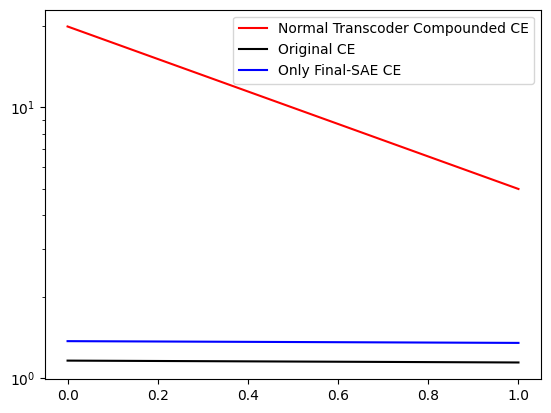

In [24]:
# Plot both losses (orig_Ce, final-CE, & Comp-CE) for normal and f2f
    # return [mse_losses, sparsity_losses, original_ces, only_final_sae_ces, compounded_ces]
from matplotlib import pyplot as plt
# plt.plot(losses_normal[2], label="Original CE", linestyle="--", color="black")
# plt.plot(losses_normal[3], label="Final SAE CE", linestyle="--", color="blue")
# plt.plot(losses_normal[4], label="Feature-2-Feature Transcoder CE", linestyle="--", color="red")
plt.plot(losses_feature_by_feature[4], label="Normal Transcoder Compounded CE", linestyle="-", color="red")
plt.plot(losses_feature_by_feature[2], label="Original CE", linestyle="-", color="black")
plt.plot(losses_feature_by_feature[3], label="Only Final-SAE CE", linestyle="-", color="blue")
plt.legend()
plt.yscale("log")
plt.show()

In [104]:
# clear the cache
# del losses
torch.cuda.empty_cache()
# garbage collect
import gc
gc.collect()
# clear the cache
torch.cuda.empty_cache()

In [77]:
tracer_kwargs = {'scan' : False, 'validate' : False}

text = " The quick brown fox jumps over the lazy dog."
tokens = torch.tensor([tokenizer.encode(text), tokenizer.encode(text)])
with torch.no_grad(), nnsight_lm.trace(tokens) as trc:
    resid_mid = nnsight_lm.torso[1].res_mlp.input.save()

resid_mid.shape

torch.Size([2, 10, 768])

In [76]:
tokens.shape

torch.Size([2, 10])

In [74]:
torch.tensor([tokenizer.encode(text), tokenizer.encode(text)])

tensor([[  10, 2529,  785,  697, 2559,  248,    2, 1235,   65,    0],
        [  10, 2529,  785,  697, 2559,  248,    2, 1235,   65,    0]])

In [46]:
nnsight_lm.device

device(type='cpu')

/tmp/ipykernel_74274/603379798.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attributions = torch.load(attribution_path, map_location=device)
/tmp/ipykernel_74274/183

Percentage of nz values: 1.85%
Mean 2001.66 | Median 1265.00


Training (Epoch 1/1):   0%|          | 0/117 [00:00<?, ?it/s]/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

Percentage of nz values: 1.18%
Mean 1275.42 | Median 617.00


Training (Epoch 1/1): 100%|██████████| 117/117 [08:16<00:00,  4.24s/it]


Percentage of nz values: 0.27%
Mean 288.47 | Median 56.00


Training (Epoch 1/1): 100%|██████████| 117/117 [08:16<00:00,  4.24s/it]


Percentage of nz values: 0.04%
Mean 42.62 | Median 5.00


Training (Epoch 1/1): 100%|██████████| 117/117 [08:16<00:00,  4.24s/it]


Percentage of nz values: 0.02%
Mean 21.17 | Median 3.00


Training (Epoch 1/1): 100%|██████████| 117/117 [08:15<00:00,  4.24s/it]


Percentage of nz values: 0.00%
Mean 1.39 | Median 1.00


Training (Epoch 1/1): 100%|██████████| 117/117 [08:16<00:00,  4.24s/it]


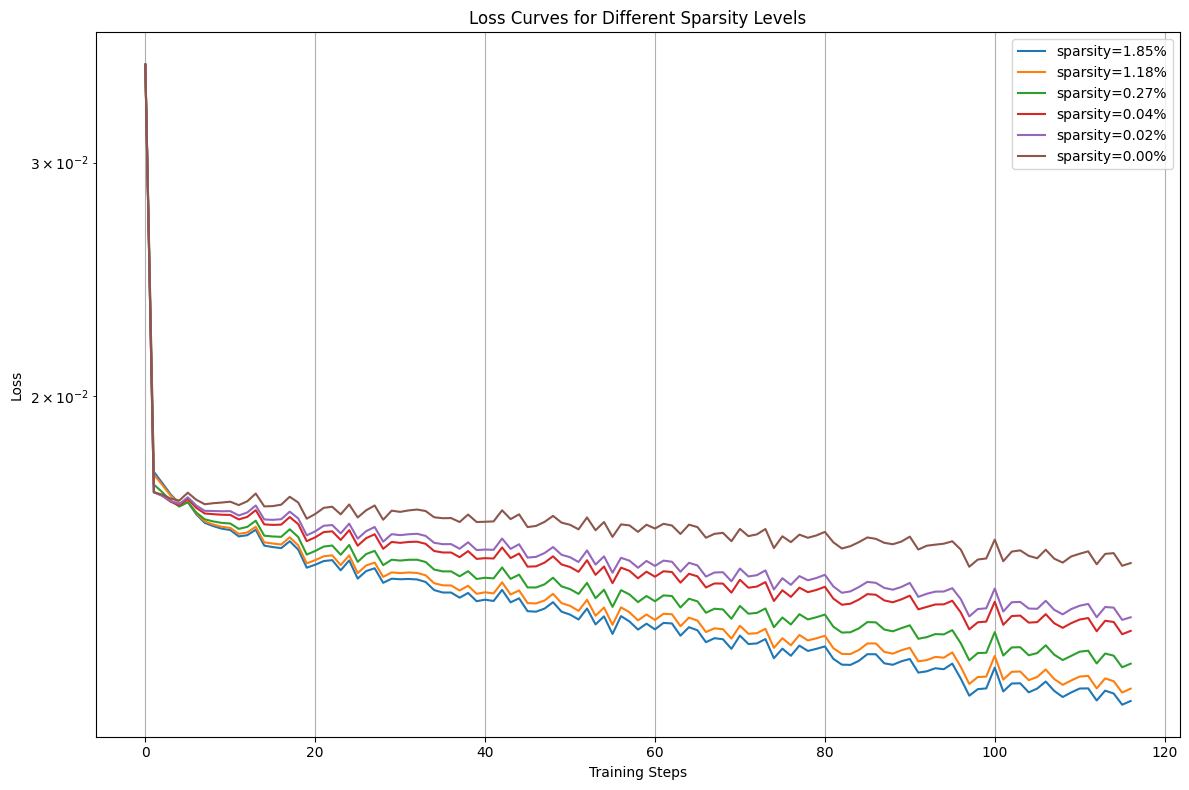


Summary of Results:
Quantile | Sparsity | Final Loss
---------|----------|------------
1.85%   | 0.0118
1.18%   | 0.0120
0.27%   | 0.0126
0.04%   | 0.0133
0.02%   | 0.0136
0.00%   | 0.0150


In [8]:
# Define quantile percentages
thresholds = [0.00005, 0.0005, 0.005, 0.05, 0.1, 0.5]
results = []

plt.figure(figsize=(12, 8))

for thresh in thresholds:
    
    # Load attributions and calculate threshold
    attributions = torch.load(attribution_path, map_location=device)

    # Create mask and calculate sparsity
    mask = create_mask(attribution_path, device, thresh).T
    sparsity =  (mask.sum().item() / mask.numel())
    print(f"Percentage of nz values: {sparsity:.2%}")
    nonzero_sum = mask.T.sum(0)
    mean_above = nonzero_sum[nonzero_sum != 0].float().mean()
    median_above = nonzero_sum[nonzero_sum != 0].float().median()
    print(f"Mean {mean_above:.2f} | Median {median_above:.2f}")
    
    # Create and initialize the model
    model = Linear(feature_size).to(device)
    
    # Train the model and get loss curve
    losses = train_model(model, dl, device, mask)
    
    # Plot loss curve
    plt.plot(losses, label=f'sparsity={sparsity:.2%}')
    
    results.append((sparsity, losses[-1]))
    
    # Move model to CPU to free up GPU memory
    model.to("cpu")
    torch.cuda.empty_cache()

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Loss Curves for Different Sparsity Levels')
plt.legend()
plt.yscale('log')  # Use log scale for y-axis to better visualize the curves
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary of results
print("\nSummary of Results:")
print("Quantile | Sparsity | Final Loss")
print("---------|----------|------------")
for sparsity, final_loss in results:
    print(f"{sparsity:.2%}   | {final_loss:.4f}")

In [30]:
nonzero_sum = mask.sum(-1)
nonzero_sum[nonzero_sum != 0].float().mean()

tensor(2176.1782, device='cuda:0')

In [20]:
thresholds = [0.00005, 0.0005, 0.005, 0.05, 0.1, 0.5]
for i in range(10, 0, -1):
    thresho = 0.1 **i*5
    num_above_threshold = attributions.abs() > thresho
    print(f"Threshold: {thresho:.5f} Percentage of non-zero values: {num_above_threshold.sum().item() / num_above_threshold.numel():.3%}")

Threshold: 0.00000 Percentage of non-zero values: 2.008%
Threshold: 0.00000 Percentage of non-zero values: 2.008%
Threshold: 0.00000 Percentage of non-zero values: 2.008%
Threshold: 0.00000 Percentage of non-zero values: 2.005%
Threshold: 0.00001 Percentage of non-zero values: 1.985%
Threshold: 0.00005 Percentage of non-zero values: 1.847%
Threshold: 0.00050 Percentage of non-zero values: 1.177%
Threshold: 0.00500 Percentage of non-zero values: 0.266%
Threshold: 0.05000 Percentage of non-zero values: 0.039%
Threshold: 0.50000 Percentage of non-zero values: 0.001%


In [21]:
attr.

tensor([1.0005, 1.0138, 1.1605,  ..., 0.0000, 0.0000, 0.0000])

In [7]:
mask.sum().item() / mask.numel()

0.0200800336

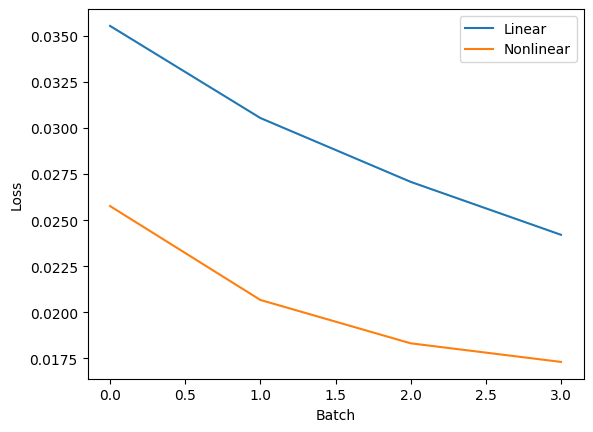

In [7]:
# Plot the results
plt.plot(linear_loss, label="Linear")
plt.plot(nonlinear_loss, label="Nonlinear")
# plt.plot(linear_all_weights_loss, label="Linear (All Weights)")
# plt.plot(nonlinear_all_weights_loss, label="Nonlinear (All Weights)")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
linear_masked.linear.weight[:, 0].topk(10), attr.T[:, 0].topk(10)

(torch.return_types.topk(
 values=tensor([0.0248, 0.0236, 0.0187, 0.0134, 0.0130, 0.0122, 0.0112, 0.0108, 0.0103,
         0.0102], grad_fn=<TopkBackward0>),
 indices=tensor([  2,   8,   0,   5,  17,  26,  13, 469, 133, 148])),
 torch.return_types.topk(
 values=tensor([0.1775, 0.1670, 0.1471, 0.1372, 0.1365, 0.1327, 0.1274, 0.1248, 0.1197,
         0.1153]),
 indices=tensor([1636, 2933, 1855, 1922, 1801, 1793, 1138, 3000, 1948, 1791])))

In [14]:
ind = [1636, 2933, 1855, 1922, 1801, 1793, 1138, 3000, 1948, 1791]
for i in ind:
    print(f"Linear Masked: {linear_masked.linear.weight[i, 0]:.6f}")

Linear Masked: 0.001534
Linear Masked: 0.000137
Linear Masked: 0.000383
Linear Masked: 0.001884
Linear Masked: 0.002633
Linear Masked: 0.000952
Linear Masked: 0.001993
Linear Masked: 0.000553
Linear Masked: 0.001578
Linear Masked: 0.001058


In [9]:
# Save all the weights
torch.save(model.linear.weight, "linear_weights.pt")
torch.save(nonlinear.linear.weight, "nonlinear_weights.pt")
torch.save(linear_all_weights.linear.weight, "linear_all_weights.pt")
torch.save(nonlinear_all_weights.linear.weight, "nonlinear_all_weights.pt")
# and biases
torch.save(nonlinear.linear.bias, "nonlinear_bias.pt")
torch.save(nonlinear_all_weights.linear.bias, "nonlinear_all_weights_bias.pt")

In [10]:
torch.save(linear_all_weights.linear.bias, "linear_all_weights_bias.pt")

In [8]:
with torch.no_grad():
    print(linear_masked.linear.weight.count_nonzero() / linear_masked.linear.weight.numel())

tensor(0.0201, device='cuda:0')


In [9]:
attr = torch.load(attribution_path)
attr.shape

/tmp/ipykernel_72079/3717689257.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attr = torch.load(attribution_path)


torch.Size([25000, 25000])

In [22]:
attr.count_nonzero() / attr.numel()

tensor(0.0201)

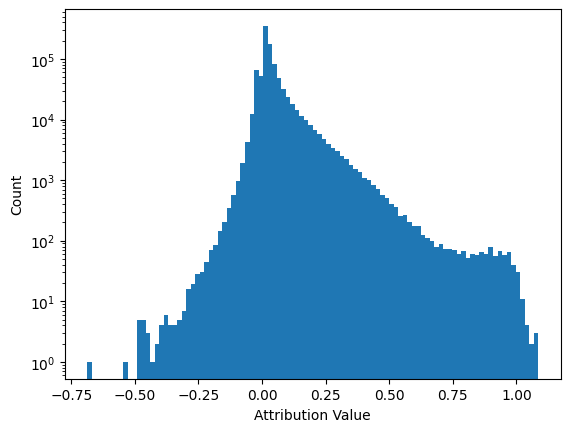

In [14]:
# plot all the nonzero values in attr
thresh = 0.01
plt.hist(attr[attr.abs() > thresh].cpu().numpy(), bins=100)
plt.xlabel("Attribution Value")
plt.ylabel("Count")
# y log
plt.yscale("log")
plt.show()

/tmp/ipykernel_74274/4032305234.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attr = torch.load(attribution_path)


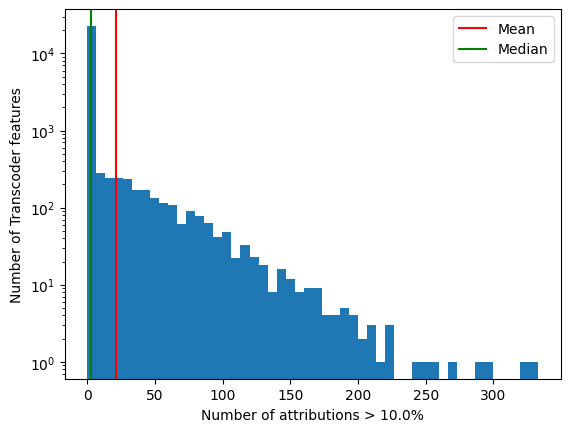

In [33]:
attr = torch.load(attribution_path)
thresh = 0.1
attr_plt = (attr.abs() > thresh).sum(dim=0).cpu()
nz_attr_ind = (attr.abs() > 0).sum(dim=0)
nz_attr = attr_plt[nz_attr_ind!=0]
plt.hist(attr_plt.numpy(), bins=50)
plt.xlabel(f"Number of attributions > {thresh*100}%")
# plot mean and median
plt.axvline(nz_attr.float().mean().numpy(), color="red", label="Mean")
plt.axvline(nz_attr.median().numpy(), color="green", label="Median")
plt.legend()
plt.ylabel("Number of Transcoder features") 
plt.yscale("log")
plt.show()

In [34]:
attr_plt[nz_attr_ind !=0].float().median(), attr_plt[nz_attr_ind !=0].float().mean()

(tensor(3.), tensor(21.1157))

In [45]:
attr.sum(0).topk(40), attr[:, 1797].topk(20)

(torch.return_types.topk(
 values=tensor([102.3982,  95.0324,  94.1689,  93.9054,  93.2533,  78.0454,  76.0404,
          73.2345,  72.6365,  71.2534,  70.1202,  69.6878,  68.3185,  65.0391,
          64.7564,  64.6958,  64.5605,  64.2277,  64.1052,  63.5514,  63.4714,
          63.3745,  63.2043,  62.9102,  62.8545,  61.9869,  60.7720,  60.6981,
          60.5872,  60.1314,  59.4586,  59.2243,  59.2014,  59.0659,  57.7527,
          57.7032,  57.0135,  56.6195,  56.3460,  56.3312]),
 indices=tensor([2728, 2718,  580, 2630, 2123, 1661, 1371, 2346, 1203, 2618, 2595, 1998,
         1267, 1975, 2094, 2669, 2180, 2502, 1742, 1722, 1939, 2975, 1914, 2028,
         2178, 2181, 2350, 2348,  730, 2111, 1772, 1246, 2396, 1384, 2070, 1007,
         2055, 2634, 1642, 1797])),
 torch.return_types.topk(
 values=tensor([0.3599, 0.3379, 0.3067, 0.2744, 0.2614, 0.2591, 0.2432, 0.2408, 0.2402,
         0.2363, 0.2318, 0.2317, 0.2313, 0.2305, 0.2241, 0.2211, 0.2157, 0.2153,
         0.2138, 0.2092]),
 i

In [53]:
attr.max(0).values.topk(10), attr.min(0).values.topk(10, largest=False), attr[:, 91].topk(10)

(torch.return_types.topk(
 values=tensor([1.0855, 1.0737, 1.0695, 1.0609, 1.0583, 1.0457, 1.0422, 1.0354, 1.0327,
         1.0308]),
 indices=tensor([1645,  264,  422, 1892, 2866, 3142, 1812, 3149, 7029, 2836])),
 torch.return_types.topk(
 values=tensor([-0.6875, -0.5391, -0.4883, -0.4590, -0.4570, -0.4453, -0.4434, -0.4414,
         -0.3906, -0.3555]),
 indices=tensor([  91,  836,   66, 1351,  244, 1389,  143, 1473, 1000, 1191])),
 torch.return_types.topk(
 values=tensor([0.4907, 0.2373, 0.1627, 0.1301, 0.1289, 0.1147, 0.1132, 0.1067, 0.1058,
         0.1056]),
 indices=tensor([   82, 20734,  3233, 16874,  2220,  4843,  7317,   338,   598,  2346])))

In [55]:
attr[:, 91].topk(10, largest=False), attr[:, 91].topk(10)

(torch.return_types.topk(
 values=tensor([-0.6875, -0.4629, -0.3068, -0.2632, -0.2236, -0.2158, -0.2148, -0.2041,
         -0.1915, -0.1694]),
 indices=tensor([ 6449,  8337,  2734,   486,  1618,  8351,  8054, 10990,  3889,  1869])),
 torch.return_types.topk(
 values=tensor([0.4907, 0.2373, 0.1627, 0.1301, 0.1289, 0.1147, 0.1132, 0.1067, 0.1058,
         0.1056]),
 indices=tensor([   82, 20734,  3233, 16874,  2220,  4843,  7317,   338,   598,  2346])))

In [51]:
fe = 1645
attr[:, fe].topk(10), attr[:, fe].topk(10, largest= False)

(torch.return_types.topk(
 values=tensor([1.0855, 0.0729, 0.0297, 0.0273, 0.0187, 0.0172, 0.0149, 0.0149, 0.0146,
         0.0123]),
 indices=tensor([  409, 18116,  7915, 17377,    93,  3349,  1195,  2793,  5779,  8472])),
 torch.return_types.topk(
 values=tensor([-0.0753, -0.0626, -0.0616, -0.0531, -0.0450, -0.0435, -0.0426, -0.0425,
         -0.0417, -0.0417]),
 indices=tensor([ 5564,   410,   182,  5837,  3187,  1725,  1705,    90, 15242,  3101])))

In [31]:
for i in range(0, 10):
    thresh = 0.1 ** i
    attr_plt = (attr.abs() > thresh).sum(dim=0).cpu()
    nz_attr_plt = attr_plt[attr_plt > 0]
    print(f"Threshold: {thresh:.7f}, Mean: {nz_attr_plt.float().mean().item():.2f}, Median: {nz_attr_plt.median().item()}")
# attr_plt = (attr.abs() > thresh).sum(dim=0).cpu()
# nz_attr_plt = attr_plt[attr_plt > 0]    
# print(f"Mean: {nz_attr_plt.float().mean().item()}")
# print(f"Median: {nz_attr_plt.median().item()}")

Threshold: 1.0000000, Mean: 1.00, Median: 1
Threshold: 0.1000000, Mean: 21.17, Median: 3
Threshold: 0.0100000, Mean: 166.13, Median: 24
Threshold: 0.0010000, Mean: 914.90, Median: 344
Threshold: 0.0001000, Mean: 1874.40, Median: 1146
Threshold: 0.0000100, Mean: 2130.99, Median: 1402
Threshold: 0.0000010, Mean: 2170.21, Median: 1438
Threshold: 0.0000001, Mean: 2175.41, Median: 1444
Threshold: 0.0000000, Mean: 2176.08, Median: 1445
Threshold: 0.0000000, Mean: 2176.17, Median: 1445


In [34]:
attr.sum(0).topk(20)

torch.return_types.topk(
values=tensor([102.3982,  95.0324,  94.1689,  93.9054,  93.2533,  78.0454,  76.0404,
         73.2345,  72.6365,  71.2534,  70.1202,  69.6878,  68.3185,  65.0391,
         64.7564,  64.6958,  64.5605,  64.2277,  64.1052,  63.5514]),
indices=tensor([2728, 2718,  580, 2630, 2123, 1661, 1371, 2346, 1203, 2618, 2595, 1998,
        1267, 1975, 2094, 2669, 2180, 2502, 1742, 1722]))

In [24]:
for x in range(0, 11):
    thresh = 0.1 **x
    total_attr_above = (attr.abs() > thresh).sum().item()
    print(f"Threshold: {thresh} Total Attr: {total_attr_above} Percentage: {total_attr_above / attr.numel()}")

Threshold: 1.0 Total Attr: 39 Percentage: 6.24e-08
Threshold: 0.1 Total Attr: 121774 Percentage: 0.0001948384
Threshold: 0.010000000000000002 Total Attr: 957765 Percentage: 0.001532424
Threshold: 0.0010000000000000002 Total Attr: 5276205 Percentage: 0.008441928
Threshold: 0.00010000000000000002 Total Attr: 10809644 Percentage: 0.0172954304
Threshold: 1.0000000000000003e-05 Total Attr: 12289446 Percentage: 0.0196631136
Threshold: 1.0000000000000004e-06 Total Attr: 12515625 Percentage: 0.020025
Threshold: 1.0000000000000004e-07 Total Attr: 12545617 Percentage: 0.0200729872
Threshold: 1.0000000000000005e-08 Total Attr: 12549468 Percentage: 0.0200791488
Threshold: 1.0000000000000005e-09 Total Attr: 12549953 Percentage: 0.0200799248
Threshold: 1.0000000000000006e-10 Total Attr: 12550012 Percentage: 0.0200800192


In [10]:
(avg_att.abs() > 0).sum()
for i in range(9,15):
    threshold = 0.1**i
    print(threshold, "| ", (avg_att.abs() > threshold).sum())

1.0000000000000005e-09 |  tensor(1560008)
1.0000000000000006e-10 |  tensor(1565056)
1.0000000000000006e-11 |  tensor(1565529)
1.0000000000000006e-12 |  tensor(1565697)
1.0000000000000007e-13 |  tensor(1565703)
1.0000000000000008e-14 |  tensor(1565703)


In [1]:
# 1560008/(25_000**2)
89375789/(25_000**2)

0.1430012624

Training (Epoch 1/1):   0%|          | 0/78 [00:00<?, ?it/s]/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this expe

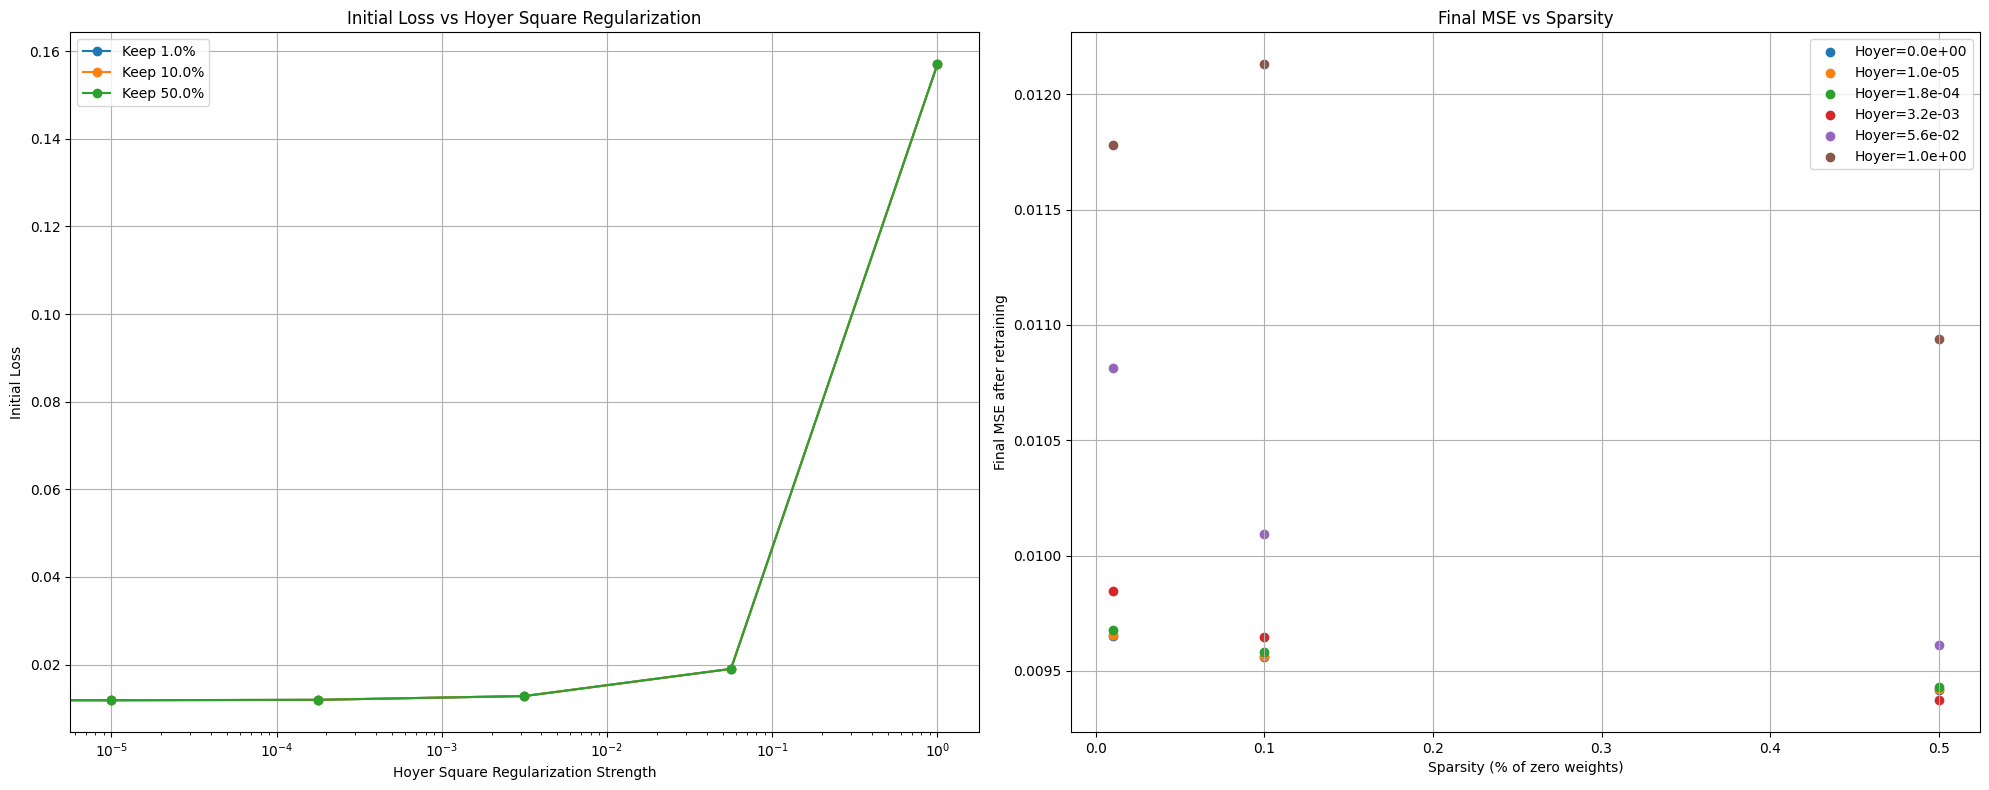

Best initial loss: 0.0119 (Hoyer=0.00e+00, Keep=1.00%)
Best sparsity: 50.00% (Hoyer=0.00e+00, Keep=50.00%)
Best final loss after retraining: 0.0094 (Hoyer=3.16e-03, Keep=50.00%, Sparsity=50.00%)


In [6]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from copy import deepcopy
class Linear(nn.Module):
    def __init__(self, input_size, bias=False, relu=False):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=bias)
        nn.init.xavier_uniform_(self.linear.weight)
        self.relu = relu
    
    def forward(self, x):
        output = self.linear(x)
        if self.relu:
            return torch.relu(output) 
        return output


def hoyer_square(w):
    """Calculate Hoyer Square for a tensor."""
    num_elements = w.numel()
    return (torch.sum(torch.abs(w)) ** 2) / (num_elements * torch.sum(w ** 2))

def train_model(model, dl, device, mask=None, hoyer_lambda=0, epochs=1):
    if mask is None:
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    else:
        opt = torch.optim.Adam([{'params': model.linear.weight, 'mask': mask}], lr=1e-3)
    
    losses = []
    
    for epoch in range(epochs):
        for batch_ind, batch in enumerate(tqdm(dl, desc=f"{'Training' if mask is None else 'Retraining'} (Epoch {epoch+1}/{epochs})")):
            batch = batch.to(device)
            with torch.no_grad():
                feature_acts_upstream = llm[activation_names[0]](batch)
                feature_acts_downstream = llm[activation_names[1]](batch)
                feature_acts_upstream = rearrange(feature_acts_upstream, "b s n -> (b s) n")
                feature_acts_downstream = rearrange(feature_acts_downstream, "b s n -> (b s) n")

            x_hat = model(feature_acts_upstream)
            residual = feature_acts_downstream - x_hat
            mse_loss = torch.mean(residual**2)
            
            if mask is None and hoyer_lambda > 0:
                # Calculate Hoyer Square regularization only during initial training
                hoyer_reg = hoyer_square(model.linear.weight)
                loss = mse_loss + hoyer_lambda * hoyer_reg
            else:
                loss = mse_loss
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if mask is not None:
                # Ensure zero weights remain zero during retraining
                with torch.no_grad():
                    model.linear.weight.data[~mask] = 0
            
            losses.append(loss.item())
    
    return losses[-1]  # Return the final loss

def threshold_weights(model, keep_percent):
    with torch.no_grad():
        weights = model.linear.weight.data
        num_elements = weights.numel()
        k = int(num_elements * (1 - keep_percent))
        
        # Flatten the weights
        flat_weights = weights.view(-1)
        
        # Use torch.topk to find the threshold value
        threshold = torch.topk(torch.abs(flat_weights), k, largest=False)[0][-1]
        
        # Create the mask
        mask = torch.abs(weights) >= threshold
        weights[~mask] = 0
    return mask

def get_sparsity(model):
    total_params = model.linear.weight.numel()
    zero_params = (model.linear.weight == 0).sum().item()
    return zero_params / total_params

def evaluate_model(model, dl, device, num_batches=3):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dl):
            if i >= num_batches:
                break
            batch = batch.to(device)
            feature_acts_upstream = llm[activation_names[0]](batch)
            feature_acts_downstream = llm[activation_names[1]](batch)
            feature_acts_upstream = rearrange(feature_acts_upstream, "b s n -> (b s) n")
            feature_acts_downstream = rearrange(feature_acts_downstream, "b s n -> (b s) n")

            x_hat = model(feature_acts_upstream)
            residual = feature_acts_downstream - x_hat
            loss = torch.mean(residual**2)
            total_loss += loss.item()
    return total_loss / num_batches

# Set up the experiment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res_size, feature_size = sae_upstream.decoder.weight.shape

hoyer_values = [0] + list(np.logspace(-5, 0, 5))  # Include 0 for no regularization
keep_percents = [0.01, 0.1, 0.5]  # Range of keep percentages

results = []

import gc
import torch

for hoyer_lambda in hoyer_values:
    model = Linear(feature_size, bias=False, relu=False).to(device)
    initial_loss = train_model(model, dl, device, hoyer_lambda=hoyer_lambda)
    
    for keep_percent in keep_percents:
        # Move model to CPU for copying and thresholding
        # print(f"Training model with Hoyer={hoyer_lambda:.2e}, Keep={keep_percent:.2%}")
        model = model.cpu()
        with torch.no_grad():
            model_copy = deepcopy(model)
            mask = threshold_weights(model_copy, keep_percent)
            # sparsity = get_sparsity(model_copy)
            sparsity = keep_percent
        
        # Move model_copy back to GPU for training
        model_copy = model_copy.to(device)
        mask = mask.to(device)
        # print("After it")
        retrained_loss = train_model(model_copy, dl, device, mask=mask, hoyer_lambda=0)
        final_loss = evaluate_model(model_copy, dl, device)
        
        results.append((hoyer_lambda, keep_percent, initial_loss, sparsity, retrained_loss, final_loss))
        
        # Clear GPU memory
        del model_copy, mask
        torch.cuda.empty_cache()
        gc.collect()
    
    # Clear GPU memory after each hoyer_lambda iteration
    del model
    torch.cuda.empty_cache()
    gc.collect()
# Convert results to numpy array for easier plotting
results_array = np.array(results)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot initial loss vs Hoyer regularization
for keep_percent in keep_percents:
    mask = results_array[:, 1] == keep_percent
    ax1.semilogx(results_array[mask, 0], results_array[mask, 2], marker='o', label=f'Keep {keep_percent:.1%}')

ax1.set_xlabel('Hoyer Square Regularization Strength')
ax1.set_ylabel('Initial Loss')
ax1.set_title('Initial Loss vs Hoyer Square Regularization')
ax1.legend()
ax1.grid(True)

# Plot final MSE vs Sparsity
for hoyer_lambda in hoyer_values:
    mask = results_array[:, 0] == hoyer_lambda
    ax2.scatter(results_array[mask, 3], results_array[mask, 5], label=f'Hoyer={hoyer_lambda:.1e}')

ax2.set_xlabel('Sparsity (% of zero weights)')
ax2.set_ylabel('Final MSE after retraining')
ax2.set_title('Final MSE vs Sparsity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print best results
best_initial_loss_idx = np.argmin(results_array[:, 2])
best_sparsity_idx = np.argmax(results_array[:, 3])
best_final_loss_idx = np.argmin(results_array[:, 5])

print(f"Best initial loss: {results_array[best_initial_loss_idx, 2]:.4f} "
      f"(Hoyer={results_array[best_initial_loss_idx, 0]:.2e}, Keep={results_array[best_initial_loss_idx, 1]:.2%})")
print(f"Best sparsity: {results_array[best_sparsity_idx, 3]:.2%} "
      f"(Hoyer={results_array[best_sparsity_idx, 0]:.2e}, Keep={results_array[best_sparsity_idx, 1]:.2%})")
print(f"Best final loss after retraining: {results_array[best_final_loss_idx, 5]:.4f} "
      f"(Hoyer={results_array[best_final_loss_idx, 0]:.2e}, Keep={results_array[best_final_loss_idx, 1]:.2%}, "
      f"Sparsity={results_array[best_final_loss_idx, 3]:.2%})")

In [9]:
# results.append((hoyer_lambda, keep_percent, initial_loss, sparsity, retrained_loss, final_loss))

results

[(0,
  0.01,
  0.011859781108796597,
  0.01,
  0.009691620245575905,
  0.009649603006740412),
 (0, 0.1, 0.011859781108796597, 0.1, 0.00960997212678194, 0.00955879595130682),
 (0,
  0.5,
  0.011859781108796597,
  0.5,
  0.009496493265032768,
  0.009416671159366766),
 (1e-05,
  0.01,
  0.011874474585056305,
  0.01,
  0.009700609371066093,
  0.009657775051891804),
 (1e-05,
  0.1,
  0.011874474585056305,
  0.1,
  0.00961869116872549,
  0.009566188479463259),
 (1e-05,
  0.5,
  0.011874474585056305,
  0.5,
  0.009504099376499653,
  0.009422902017831802),
 (0.00017782794100389227,
  0.01,
  0.011972786858677864,
  0.01,
  0.009716126136481762,
  0.009676004759967327),
 (0.00017782794100389227,
  0.1,
  0.011972786858677864,
  0.1,
  0.009631451219320297,
  0.009581273421645164),
 (0.00017782794100389227,
  0.5,
  0.011972786858677864,
  0.5,
  0.009509162046015263,
  0.009429124183952808),
 (0.0031622776601683794,
  0.01,
  0.012832130305469036,
  0.01,
  0.009882180951535702,
  0.00984562778

GPU memory allocated: 0.194100736 GB
Training MLP...


Epoch 1/1:   1%|          | 1/156 [00:02<07:37,  2.95s/it]

MLP - Epoch 1, Batch 0, Loss: 0.026032401248812675


Epoch 1/1:   7%|▋         | 11/156 [00:32<07:07,  2.95s/it]

MLP - Epoch 1, Batch 10, Loss: 0.020051825791597366


Epoch 1/1:  13%|█▎        | 21/156 [01:01<06:38,  2.95s/it]

MLP - Epoch 1, Batch 20, Loss: 0.017248880118131638


Epoch 1/1:  20%|█▉        | 31/156 [01:31<06:08,  2.94s/it]

MLP - Epoch 1, Batch 30, Loss: 0.016912270337343216


Epoch 1/1:  26%|██▋       | 41/156 [02:00<05:37,  2.94s/it]

MLP - Epoch 1, Batch 40, Loss: 0.017019474878907204


Epoch 1/1:  33%|███▎      | 51/156 [02:29<05:09,  2.95s/it]

MLP - Epoch 1, Batch 50, Loss: 0.017158474773168564


Epoch 1/1:  39%|███▉      | 61/156 [02:59<04:39,  2.94s/it]

MLP - Epoch 1, Batch 60, Loss: 0.01712878979742527


Epoch 1/1:  46%|████▌     | 71/156 [03:28<04:11,  2.96s/it]

MLP - Epoch 1, Batch 70, Loss: 0.016916289925575256


Epoch 1/1:  52%|█████▏    | 81/156 [03:58<03:42,  2.97s/it]

MLP - Epoch 1, Batch 80, Loss: 0.016233986243605614


Epoch 1/1:  58%|█████▊    | 91/156 [04:28<03:13,  2.98s/it]

MLP - Epoch 1, Batch 90, Loss: 0.01708914525806904


Epoch 1/1:  65%|██████▍   | 101/156 [04:58<02:43,  2.98s/it]

MLP - Epoch 1, Batch 100, Loss: 0.016249187290668488


Epoch 1/1:  71%|███████   | 111/156 [05:27<02:13,  2.98s/it]

MLP - Epoch 1, Batch 110, Loss: 0.016649071127176285


Epoch 1/1:  78%|███████▊  | 121/156 [05:57<01:44,  2.98s/it]

MLP - Epoch 1, Batch 120, Loss: 0.016491606831550598


Epoch 1/1:  84%|████████▍ | 131/156 [06:27<01:14,  2.99s/it]

MLP - Epoch 1, Batch 130, Loss: 0.016619332134723663


Epoch 1/1:  90%|█████████ | 141/156 [06:57<00:44,  2.99s/it]

MLP - Epoch 1, Batch 140, Loss: 0.016838308423757553


Epoch 1/1:  97%|█████████▋| 151/156 [07:27<00:14,  2.99s/it]

MLP - Epoch 1, Batch 150, Loss: 0.01664220541715622


Epoch 1/1: 100%|██████████| 156/156 [07:41<00:00,  2.96s/it]


GPU memory allocated: 10.194503168 GB
Training Linear (No Bias, No ReLU)...


Epoch 1/1:   1%|          | 1/156 [00:01<04:35,  1.78s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 0, Loss: 0.03540676087141037


Epoch 1/1:   7%|▋         | 11/156 [00:19<04:18,  1.78s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 10, Loss: 0.018643254414200783


Epoch 1/1:  13%|█▎        | 21/156 [00:37<03:58,  1.77s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 20, Loss: 0.01664019376039505


Epoch 1/1:  20%|█▉        | 31/156 [00:54<03:44,  1.79s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 30, Loss: 0.015042005106806755


Epoch 1/1:  26%|██▋       | 41/156 [01:12<03:21,  1.76s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 40, Loss: 0.014229496009647846


Epoch 1/1:  33%|███▎      | 51/156 [01:30<03:05,  1.77s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 50, Loss: 0.013746662065386772


Epoch 1/1:  39%|███▉      | 61/156 [01:48<02:56,  1.86s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 60, Loss: 0.013236457481980324


Epoch 1/1:  46%|████▌     | 71/156 [02:06<02:30,  1.78s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 70, Loss: 0.012533556669950485


Epoch 1/1:  52%|█████▏    | 81/156 [02:23<02:12,  1.77s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 80, Loss: 0.011613194830715656


Epoch 1/1:  58%|█████▊    | 91/156 [02:41<01:56,  1.79s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 90, Loss: 0.01197922881692648


Epoch 1/1:  65%|██████▍   | 101/156 [02:59<01:37,  1.78s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 100, Loss: 0.010867727920413017


Epoch 1/1:  71%|███████   | 111/156 [03:16<01:19,  1.76s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 110, Loss: 0.011080095544457436


Epoch 1/1:  78%|███████▊  | 121/156 [03:34<01:00,  1.74s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 120, Loss: 0.01067421305924654


Epoch 1/1:  84%|████████▍ | 131/156 [03:51<00:44,  1.77s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 130, Loss: 0.010416701436042786


Epoch 1/1:  90%|█████████ | 141/156 [04:09<00:26,  1.76s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 140, Loss: 0.01039375364780426


Epoch 1/1:  97%|█████████▋| 151/156 [04:27<00:08,  1.78s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 150, Loss: 0.010029196739196777


Epoch 1/1: 100%|██████████| 156/156 [04:35<00:00,  1.77s/it]


GPU memory allocated: 15.19450368 GB
Training Linear (Bias + ReLU)...


Epoch 1/1:   1%|          | 1/156 [00:01<04:33,  1.77s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 0, Loss: 0.025700272992253304


Epoch 1/1:   7%|▋         | 11/156 [00:19<04:16,  1.77s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 10, Loss: 0.016260525211691856


Epoch 1/1:  13%|█▎        | 21/156 [00:37<04:00,  1.78s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 20, Loss: 0.015453878790140152


Epoch 1/1:  20%|█▉        | 31/156 [00:54<03:37,  1.74s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 30, Loss: 0.014398421160876751


Epoch 1/1:  26%|██▋       | 41/156 [01:12<03:20,  1.74s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 40, Loss: 0.013762942515313625


Epoch 1/1:  33%|███▎      | 51/156 [01:29<03:04,  1.76s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 50, Loss: 0.01329282857477665


Epoch 1/1:  39%|███▉      | 61/156 [01:47<02:48,  1.77s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 60, Loss: 0.01276557706296444


Epoch 1/1:  46%|████▌     | 71/156 [02:05<02:29,  1.76s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 70, Loss: 0.011993412859737873


Epoch 1/1:  52%|█████▏    | 81/156 [02:22<02:11,  1.75s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 80, Loss: 0.01100083813071251


Epoch 1/1:  58%|█████▊    | 91/156 [02:40<01:54,  1.76s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 90, Loss: 0.011377210728824139


Epoch 1/1:  65%|██████▍   | 101/156 [02:57<01:38,  1.78s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 100, Loss: 0.010145217180252075


Epoch 1/1:  71%|███████   | 111/156 [03:15<01:19,  1.77s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 110, Loss: 0.010332956910133362


Epoch 1/1:  78%|███████▊  | 121/156 [03:33<01:02,  1.78s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 120, Loss: 0.009882220067083836


Epoch 1/1:  84%|████████▍ | 131/156 [03:51<00:44,  1.76s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 130, Loss: 0.00966595858335495


Epoch 1/1:  90%|█████████ | 141/156 [04:09<00:26,  1.78s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 140, Loss: 0.009642110206186771


Epoch 1/1:  97%|█████████▋| 151/156 [04:26<00:08,  1.76s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 150, Loss: 0.009195865131914616


Epoch 1/1: 100%|██████████| 156/156 [04:35<00:00,  1.76s/it]


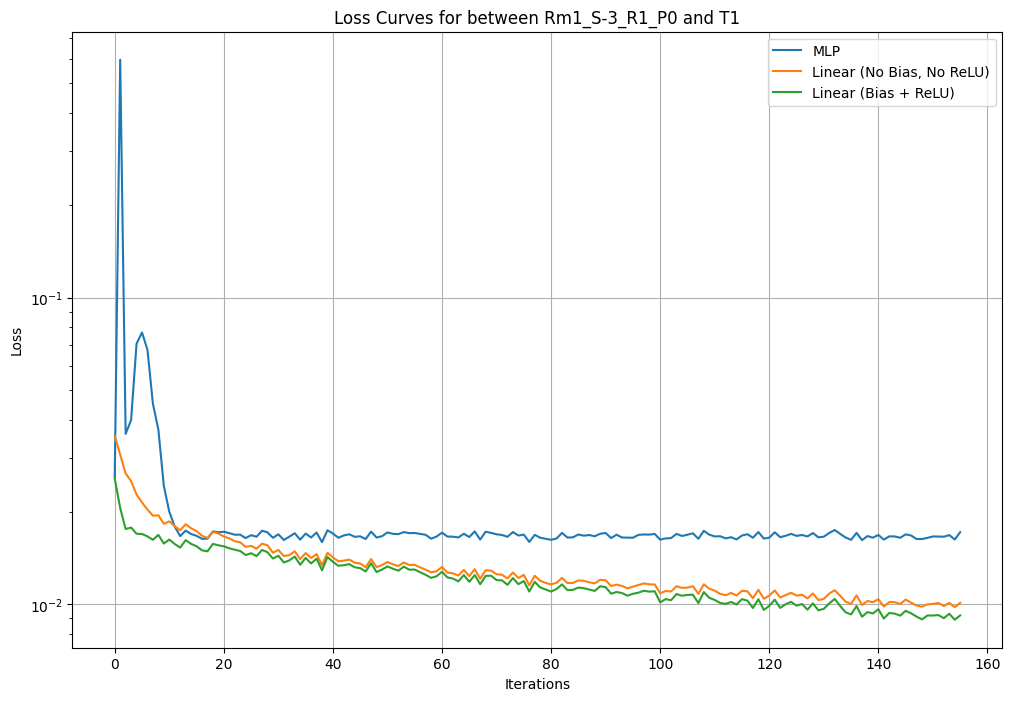

In [7]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm

class Linear(nn.Module):
    def __init__(self, input_size, bias=False, relu=False):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=bias)
        nn.init.xavier_uniform_(self.linear.weight)
        self.relu = relu
    
    def forward(self, x):
        output = self.linear(x)
        if self.relu:
            return torch.relu(output) 
        return output

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bias=False):
        super().__init__()
        self.linear_first = nn.Linear(input_size, hidden_size, bias=bias)
        self.linear_second = nn.Linear(hidden_size, output_size, bias=bias)
        nn.init.xavier_uniform_(self.linear_first.weight)
        nn.init.xavier_uniform_(self.linear_second.weight)
    
    def forward(self, x):
        output = self.linear_first(x)
        output = torch.relu(output)
        output = self.linear_second(output)
        return output

def train_model(model, dl, model_name, device, num_epochs=1):
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    losses = []
    
    for epoch in range(num_epochs):
        epoch_losses = []
        for batch_ind, batch in enumerate(tqdm(dl, desc=f"Epoch {epoch+1}/{num_epochs}")):
            batch = batch.to(device)
            with torch.no_grad():
                feature_acts_upstream = llm[activation_names[0]](batch)
                feature_acts_downstream = llm[activation_names[1]](batch)
                feature_acts_upstream = rearrange(feature_acts_upstream, "b s n -> (b s) n")
                feature_acts_downstream = rearrange(feature_acts_downstream, "b s n -> (b s) n")

            x_hat = model(feature_acts_upstream)
            residual = feature_acts_downstream - x_hat
            opt.zero_grad()
            loss = torch.mean(residual**2)
            loss.backward()
            opt.step()
            
            epoch_losses.append(loss.item())
            
            if batch_ind % 10 == 0:
                print(f"{model_name} - Epoch {epoch+1}, Batch {batch_ind}, Loss: {loss.item()}")
        
        losses.extend(epoch_losses)
    
    return losses

# Set up models
res_size, feature_size = sae_upstream.decoder.weight.shape
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

linear_no_bias_no_relu = Linear(feature_size, bias=False, relu=False)
linear_bias_relu = Linear(feature_size, bias=True, relu=True)
mlp_model = MLP(feature_size, feature_size, feature_size, bias=True)

# Train models
models = [
    (mlp_model, "MLP"),
    (linear_no_bias_no_relu, "Linear (No Bias, No ReLU)"),
    (linear_bias_relu, "Linear (Bias + ReLU)"),
]

all_losses = {}

for model, model_name in models:
    # print GPU torch memory in GB
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9} GB")
    print(f"Training {model_name}...")
    losses = train_model(model.to(device), dl, model_name, device)
    all_losses[model_name] = losses


# Plot loss curves
plt.figure(figsize=(12, 8))
for model_name, losses in all_losses.items():
    plt.plot(losses, label=model_name)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title(f"Loss Curves for between {activation_names[0]} and {activation_names[1]}")
plt.legend()
plt.yscale("log")  # Use log scale for y-axis to better visualize differences
plt.grid(True)
plt.show()

Training (L2=1e-05):   0%|          | 0/8 [00:00<?, ?it/s]/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

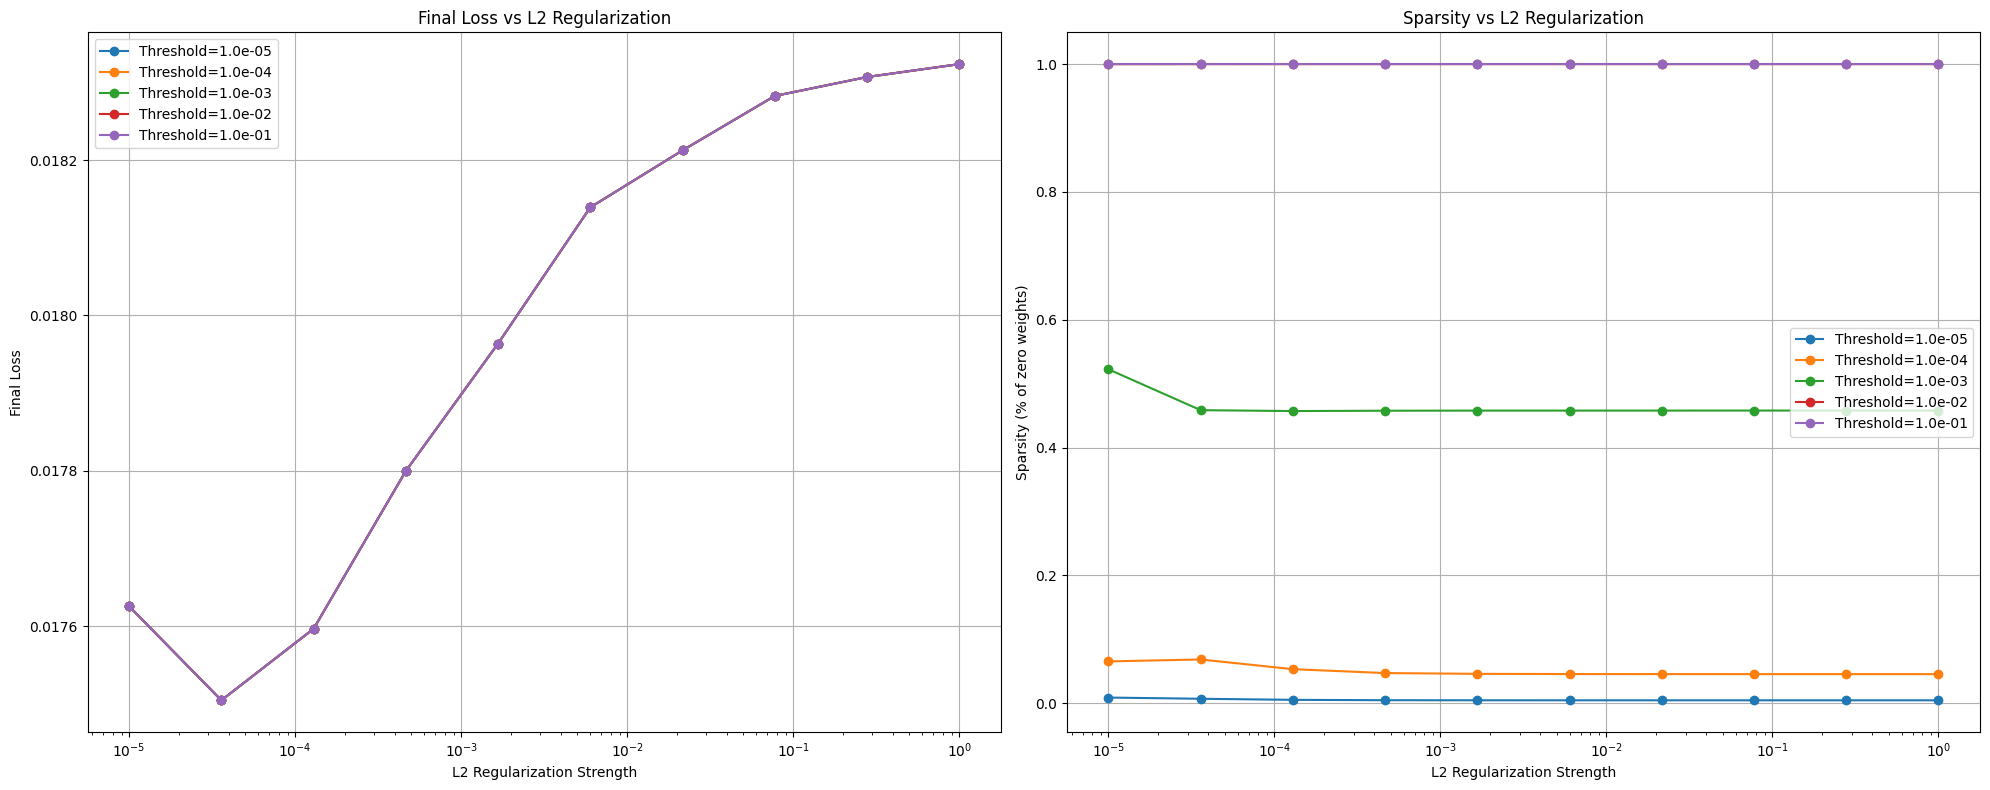

Best loss: 0.0175 (L2=3.59e-05, Threshold=1.00e-05)
Best sparsity: 100.00% (L2=1.00e-05, Threshold=1.00e-01)


In [6]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from copy import deepcopy

import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm

class Linear(nn.Module):
    def __init__(self, input_size, bias=False, relu=False):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=bias)
        nn.init.xavier_uniform_(self.linear.weight)
        self.relu = relu
    
    def forward(self, x):
        output = self.linear(x)
        if self.relu:
            return torch.relu(output) 
        return output

def train_model(model, dl, device, l2_lambda=0.01):
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=l2_lambda)
    losses = []
    
    for batch_ind, batch in enumerate(tqdm(dl, desc=f"Training (L2={l2_lambda})")):
        batch = batch.to(device)
        with torch.no_grad():
            feature_acts_upstream = llm[activation_names[0]](batch)
            feature_acts_downstream = llm[activation_names[1]](batch)
            feature_acts_upstream = rearrange(feature_acts_upstream, "b s n -> (b s) n")
            feature_acts_downstream = rearrange(feature_acts_downstream, "b s n -> (b s) n")

        x_hat = model(feature_acts_upstream)
        residual = feature_acts_downstream - x_hat
        loss = torch.mean(residual**2)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
    
    return losses[-1]  # Return the final loss

def threshold_weights(model, threshold):
    with torch.no_grad():
        for param in model.parameters():
            param.data[torch.abs(param.data) < threshold] = 0

def get_sparsity(model):
    total_params = sum(p.numel() for p in model.parameters())
    zero_params = sum((p == 0).sum().item() for p in model.parameters())
    return zero_params / total_params

# Set up the experiment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res_size, feature_size = sae_upstream.decoder.weight.shape

l2_values = np.logspace(-5, 0, 10)  # Range of L2 regularization values
threshold_values = np.logspace(-5, -1, 5)  # Range of threshold values

results = []

for l2_lambda in l2_values:
    model = Linear(feature_size, bias=False, relu=False).to(device)
    final_loss = train_model(model, dl, device, l2_lambda)
    
    for threshold in threshold_values:
        model_copy = deepcopy(model)
        threshold_weights(model_copy, threshold)
        sparsity = get_sparsity(model_copy)
        results.append((l2_lambda, threshold, final_loss, sparsity))

# Convert results to numpy array for easier plotting
results_array = np.array(results)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot final loss
for threshold in threshold_values:
    mask = results_array[:, 1] == threshold
    ax1.semilogx(results_array[mask, 0], results_array[mask, 2], marker='o', label=f'Threshold={threshold:.1e}')

ax1.set_xlabel('L2 Regularization Strength')
ax1.set_ylabel('Final Loss')
ax1.set_title('Final Loss vs L2 Regularization')
ax1.legend()
ax1.grid(True)

# Plot sparsity
for threshold in threshold_values:
    mask = results_array[:, 1] == threshold
    ax2.semilogx(results_array[mask, 0], results_array[mask, 3], marker='o', label=f'Threshold={threshold:.1e}')

ax2.set_xlabel('L2 Regularization Strength')
ax2.set_ylabel('Sparsity (% of zero weights)')
ax2.set_title('Sparsity vs L2 Regularization')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print best results
best_loss_idx = np.argmin(results_array[:, 2])
best_sparsity_idx = np.argmax(results_array[:, 3])

print(f"Best loss: {results_array[best_loss_idx, 2]:.4f} "
      f"(L2={results_array[best_loss_idx, 0]:.2e}, Threshold={results_array[best_loss_idx, 1]:.2e})")
print(f"Best sparsity: {results_array[best_sparsity_idx, 3]:.2%} "
      f"(L2={results_array[best_sparsity_idx, 0]:.2e}, Threshold={results_array[best_sparsity_idx, 1]:.2e})")

Training (L2=1e-05):   0%|          | 0/8 [00:00<?, ?it/s]/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

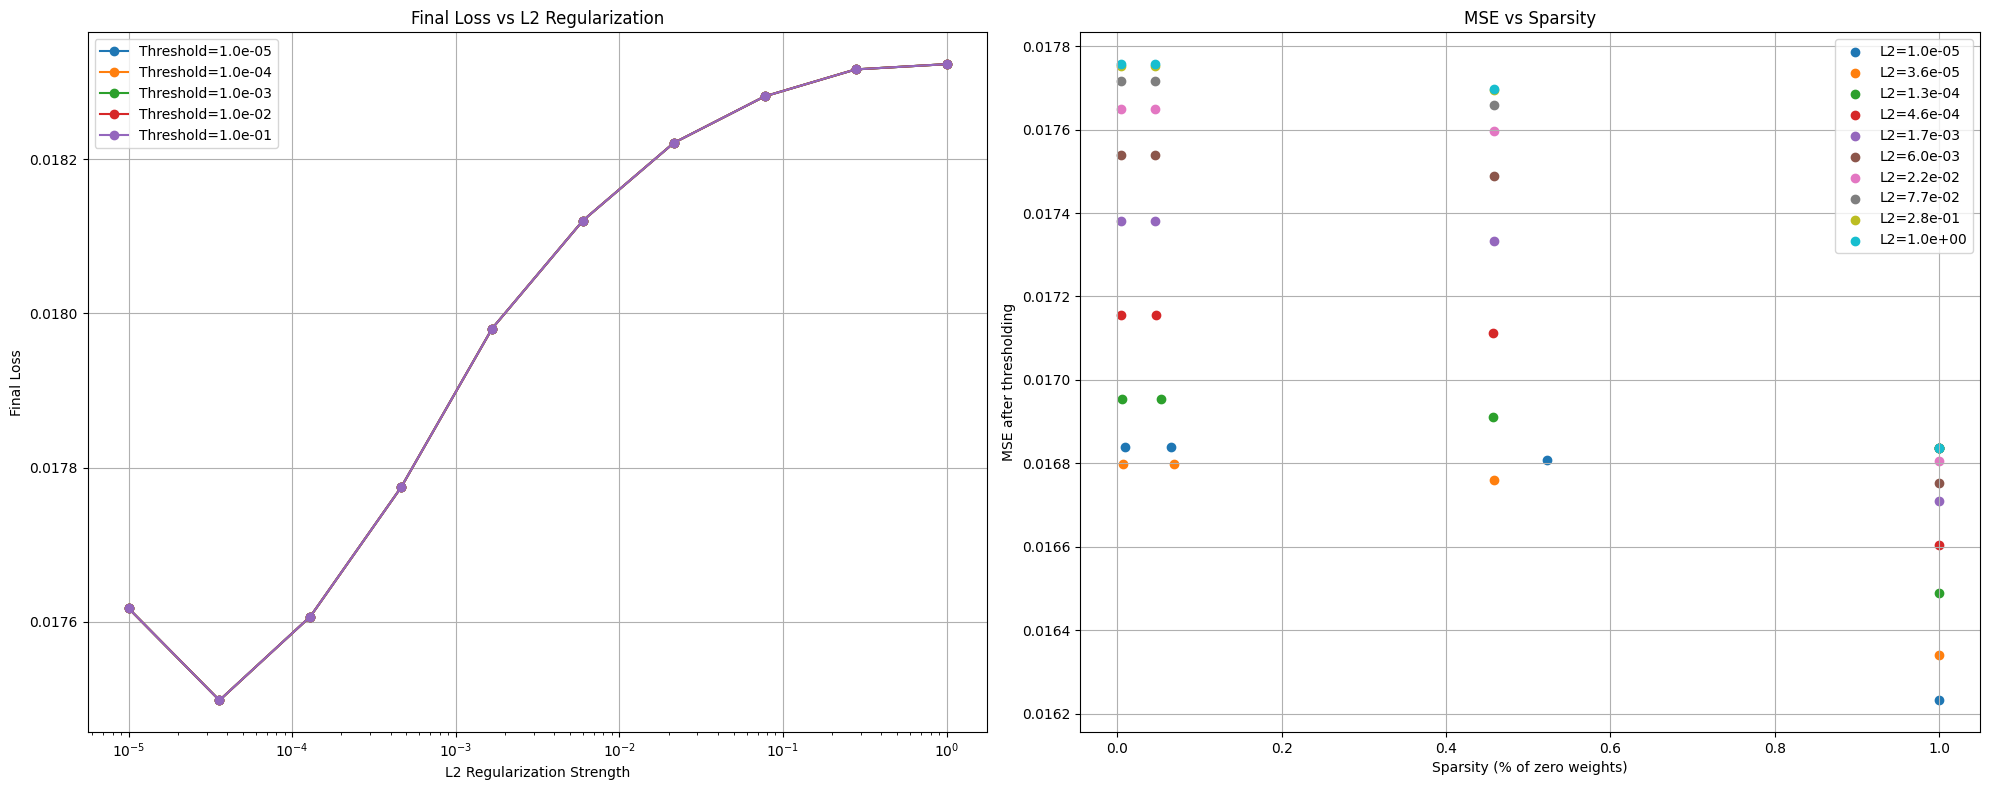

Best initial loss: 0.0175 (L2=3.59e-05, Threshold=1.00e-05)
Best sparsity: 100.00% (L2=1.00e-05, Threshold=1.00e-01)
Best loss after thresholding: 0.0162 (L2=1.00e-05, Threshold=1.00e-02, Sparsity=99.99%)


In [8]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from copy import deepcopy

# Assuming Linear class and other necessary functions are defined as before

def train_model(model, dl, device, l2_lambda=0.01):
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=l2_lambda)
    losses = []
    
    for batch_ind, batch in enumerate(tqdm(dl, desc=f"Training (L2={l2_lambda})")):
        batch = batch.to(device)
        with torch.no_grad():
            feature_acts_upstream = llm[activation_names[0]](batch)
            feature_acts_downstream = llm[activation_names[1]](batch)
            feature_acts_upstream = rearrange(feature_acts_upstream, "b s n -> (b s) n")
            feature_acts_downstream = rearrange(feature_acts_downstream, "b s n -> (b s) n")

        x_hat = model(feature_acts_upstream)
        residual = feature_acts_downstream - x_hat
        loss = torch.mean(residual**2)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
    
    return losses[-1]  # Return the final loss

def threshold_weights(model, threshold):
    with torch.no_grad():
        for param in model.parameters():
            param.data[torch.abs(param.data) < threshold] = 0

def get_sparsity(model):
    total_params = sum(p.numel() for p in model.parameters())
    zero_params = sum((p == 0).sum().item() for p in model.parameters())
    return zero_params / total_params

def evaluate_model(model, dl, device, num_batches=3):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dl):
            if i >= num_batches:
                break
            batch = batch.to(device)
            feature_acts_upstream = llm[activation_names[0]](batch)
            feature_acts_downstream = llm[activation_names[1]](batch)
            feature_acts_upstream = rearrange(feature_acts_upstream, "b s n -> (b s) n")
            feature_acts_downstream = rearrange(feature_acts_downstream, "b s n -> (b s) n")

            x_hat = model(feature_acts_upstream)
            residual = feature_acts_downstream - x_hat
            loss = torch.mean(residual**2)
            total_loss += loss.item()
    return total_loss / num_batches

# Set up the experiment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res_size, feature_size = sae_upstream.decoder.weight.shape

l2_values = np.logspace(-5, 0, 10)  # Range of L2 regularization values
threshold_values = np.logspace(-5, -1, 5)  # Range of threshold values

results = []

for l2_lambda in l2_values:
    model = Linear(feature_size, bias=False, relu=False).to(device)
    final_loss = train_model(model, dl, device, l2_lambda)
    
    for threshold in threshold_values:
        model_copy = deepcopy(model)
        threshold_weights(model_copy, threshold)
        sparsity = get_sparsity(model_copy)
        new_loss = evaluate_model(model_copy, dl, device)
        results.append((l2_lambda, threshold, final_loss, sparsity, new_loss))

# Convert results to numpy array for easier plotting
results_array = np.array(results)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot final loss vs L2 regularization
for threshold in threshold_values:
    mask = results_array[:, 1] == threshold
    ax1.semilogx(results_array[mask, 0], results_array[mask, 2], marker='o', label=f'Threshold={threshold:.1e}')

ax1.set_xlabel('L2 Regularization Strength')
ax1.set_ylabel('Final Loss')
ax1.set_title('Final Loss vs L2 Regularization')
ax1.legend()
ax1.grid(True)

# Plot MSE vs Sparsity
for l2_lambda in l2_values:
    mask = results_array[:, 0] == l2_lambda
    ax2.scatter(results_array[mask, 3], results_array[mask, 4], label=f'L2={l2_lambda:.1e}')

ax2.set_xlabel('Sparsity (% of zero weights)')
ax2.set_ylabel('MSE after thresholding')
ax2.set_title('MSE vs Sparsity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print best results
best_loss_idx = np.argmin(results_array[:, 2])
best_sparsity_idx = np.argmax(results_array[:, 3])
best_new_loss_idx = np.argmin(results_array[:, 4])

print(f"Best initial loss: {results_array[best_loss_idx, 2]:.4f} "
      f"(L2={results_array[best_loss_idx, 0]:.2e}, Threshold={results_array[best_loss_idx, 1]:.2e})")
print(f"Best sparsity: {results_array[best_sparsity_idx, 3]:.2%} "
      f"(L2={results_array[best_sparsity_idx, 0]:.2e}, Threshold={results_array[best_sparsity_idx, 1]:.2e})")
print(f"Best loss after thresholding: {results_array[best_new_loss_idx, 4]:.4f} "
      f"(L2={results_array[best_new_loss_idx, 0]:.2e}, Threshold={results_array[best_new_loss_idx, 1]:.2e}, "
      f"Sparsity={results_array[best_new_loss_idx, 3]:.2%})")

In [9]:
model = Linear(feature_size, bias=False, relu=False).to(device)
random_loss = evaluate_model(model, dl, device)
random_loss

/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


0.0356332336862882

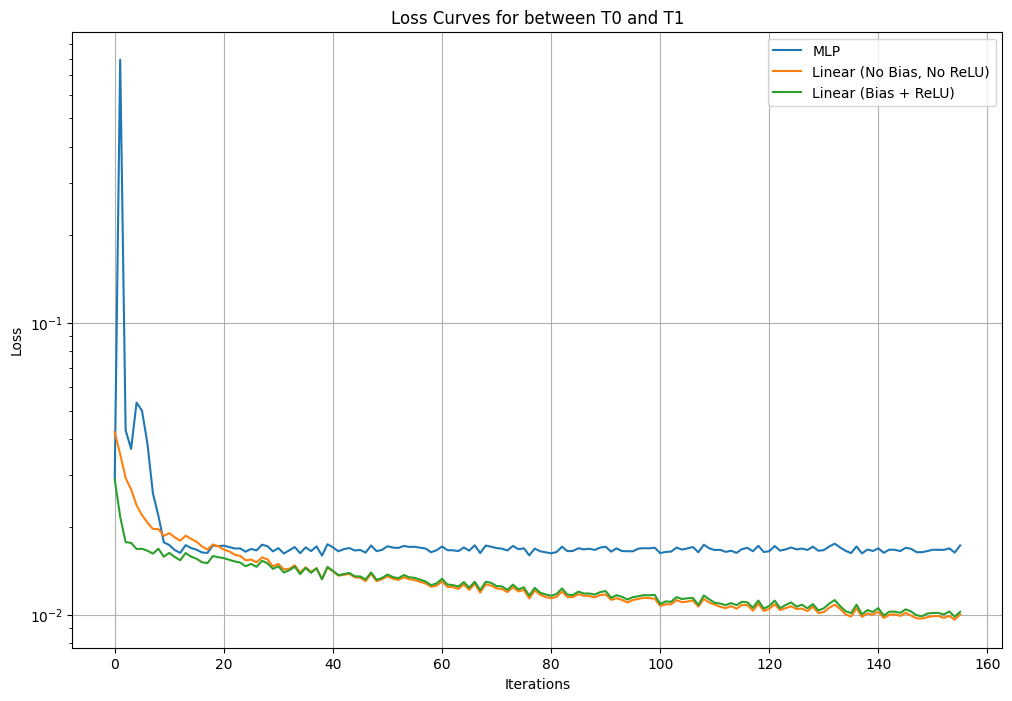

In [6]:
# Plot loss curves
plt.figure(figsize=(12, 8))
for model_name, losses in all_losses.items():
    plt.plot(losses, label=model_name)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title(f"Loss Curves for between {activation_names[0]} and {activation_names[1]}")
plt.legend()
plt.yscale("log")  # Use log scale for y-axis to better visualize differences
plt.grid(True)
plt.show()

In [10]:
# clear cuda memory
torch.cuda.empty_cache()

for model, model_name in list(models[2:]):
    print(f"Training {model_name}...")
    losses = train_model(model, dl, model_name, device)
    all_losses[model_name] = losses


Training MLP...


Epoch 1/1:   0%|          | 0/78 [00:00<?, ?it/s]/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.41 GiB. GPU 0 has a total capacity of 47.54 GiB of which 1.66 GiB is free. Process 3242196 has 45.88 GiB memory in use. Of the allocated memory 44.66 GiB is allocated by PyTorch, and 41.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

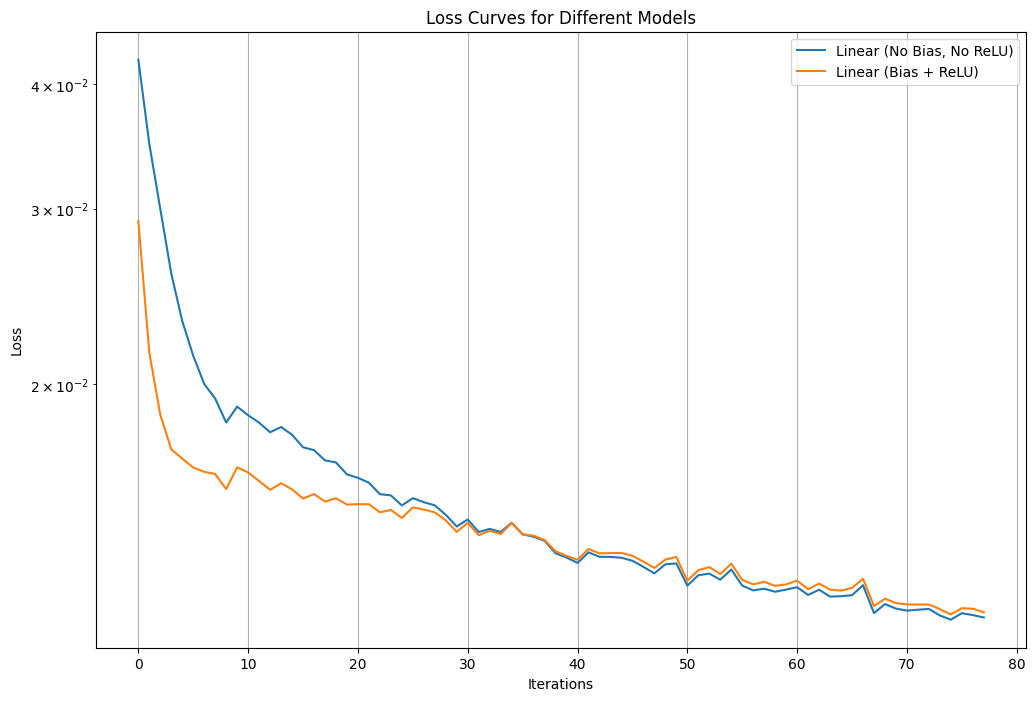

In [6]:
# Plot loss curves
plt.figure(figsize=(12, 8))
for model_name, losses in all_losses.items():
    plt.plot(losses, label=model_name)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Curves for Different Models")
plt.legend()
plt.yscale("log")  # Use log scale for y-axis to better visualize differences
plt.grid(True)
plt.show()

In [18]:
from torch import nn
class linear(nn.Module):
    def __init__(self, input_size, bias=False, relu=False):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=bias)
        nn.init.xavier_uniform_(self.linear.weight)
        self.relu = relu
    def forward(self, x):
        output = self.linear(x)
        if self.relu:
            return torch.relu(output) 
        return output
    
class mlp(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bias=False):
        super().__init__()
        self.linear_first = nn.Linear(input_size, hidden_size, bias=bias)
        self.linear_second = nn.Linear(hidden_size, output_size, bias=bias)
        nn.init.xavier_uniform_(self.linear_first.weight)
        nn.init.xavier_uniform_(self.linear_second.weight)
    def forward(self, x):
        output = self.linear_first(x)
        output = torch.relu(output)
        output = self.linear_second(output)
        return output
    
res_size, feature_size = sae_upstream.decoder.weight.shape
linear_layer = linear(feature_size, bias=False, relu=False).to(device)
opt = torch.optim.Adam(linear_layer.parameters(), lr=1e-3)

In [19]:
for batch_ind, batch in enumerate(tqdm(dl)):
    batch = batch.to(model.device)
    with torch.no_grad():
        feature_acts_upstream = model[activation_names[0]](batch)
        feature_acts_downstream = model[activation_names[1]](batch)
        feature_acts_upstream = rearrange(feature_acts_upstream, "b s n -> (b s) n" )
        feature_acts_downstream = rearrange(feature_acts_downstream, "b s n -> (b s) n" )

    x_hat = linear_layer(feature_acts_upstream)
    residual = feature_acts_downstream - x_hat
    opt.zero_grad()
    loss = torch.mean(residual**2)
    loss.backward()
    opt.step()
    if batch_ind % 10 == 0:
        print(f"Loss: {loss.item()}")

  1%|▏         | 1/78 [00:02<03:20,  2.60s/it]

Loss: 0.04235541447997093


 14%|█▍        | 11/78 [00:28<03:24,  3.06s/it]

Loss: 0.018634028732776642


 27%|██▋       | 21/78 [00:54<02:56,  3.10s/it]

Loss: 0.016137197613716125


 40%|███▉      | 31/78 [01:20<02:24,  3.08s/it]

Loss: 0.014654598198831081


 53%|█████▎    | 41/78 [01:45<01:53,  3.07s/it]

Loss: 0.013249070383608341


 65%|██████▌   | 51/78 [02:11<01:23,  3.10s/it]

Loss: 0.0125730000436306


 78%|███████▊  | 61/78 [02:37<00:52,  3.10s/it]

Loss: 0.012530181556940079


 91%|█████████ | 71/78 [03:03<00:21,  3.11s/it]

Loss: 0.011866397224366665


100%|██████████| 78/78 [03:19<00:00,  2.56s/it]


In [15]:
loss

tensor(0.0237, device='cuda:0', grad_fn=<MeanBackward0>)